# DATA PREPARATION, CLEANING, PREPROCESSING

## Import important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", 80)
pd.set_option("display.max_columns", 80)

%matplotlib inline
sns.set()

## Import dataset

In [2]:
from re import sub
from decimal import Decimal

def convert(string):
    result = Decimal(sub(r'[^\d.]', '', string))
    
    return str(result)

All prices ("price" and "extra_people") are currently in a `string` format. We will remove the dollar signs and convert it to numerical values.

In [3]:
df = pd.read_csv("data/listings.csv")

# We are using the convert() function above to change "price" to the correct datatype
df["price"] = df["price"].apply(convert).astype("float")
df["extra_people"] = df["extra_people"].apply(convert).astype("float")

# Get a random preview of the DataFrame
df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,49091,https://www.airbnb.com/rooms/49091,20191228164401,2019-12-28,COZICOMFORT LONG TERM STAY ROOM 2,NaN,This is Room No. 2.(available after Jan 15 201...,This is Room No. 2.(available after Jan 15 201...,none,NaN,NaN,NaN,NaN,NaN,No smoking indoors. Please turn off lights/fan...,NaN,NaN,https://a0.muscache.com/im/pictures/24485541/6...,NaN,266763,https://www.airbnb.com/users/show/266763,Francesca,2010-10-20,singapore,I am a private tutor by profession. My husband...,within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/c9b1c...,https://a0.muscache.com/im/pictures/user/c9b1c...,Woodlands,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,"Singapore, Singapore",Woodlands,Woodlands,...,14.0,180,360,180,180,360,360,180.0,360.0,67 months ago,t,30,60,90,365,2019-12-28,1,0,2013-10-21,2013-10-21,94.0,10.0,10.0,10.0,10.0,8.0,8.0,f,NaN,NaN,f,f,flexible,t,t,2,0,2,0,0.01
1,50646,https://www.airbnb.com/rooms/50646,20191228164401,2019-12-28,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,"Good Condition room, bright & windy. Comes wit...",Fully furnished bedroom with a nice view on th...,none,The serenity & quiet surrounding makes it an i...,Accommodation has a queen size bed. Suitable ...,Less than 400m from the apartment is the main ...,"Kitchen, washing facilities, gym, swimming poo...",We love to host people & have the opportunity ...,'- Should be family friendly. '- Cooking is no...,NaN,NaN,https://a0.muscache.com/im/pictures/36342984/6...,NaN,227796,https://www.airbnb.com/users/show/227796,Sujatha,2010-09-08,"Singapore, Singapore","I am a working professional, living in Singapo...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/8fd2c...,https://a0.muscache.com/im/pictures/user/8fd2c...,Bukit Timah,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,f,"Singapore, Singapore",Bukit Timah,Bukit Timah,...,20.0,90,730,90,90,730,730,90.0,730.0,65 months ago,t,30,60,90,365,2019-12-28,18,0,2014-04-18,2014-12-26,91.0,9.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,f,moderate,f,t,1,0,1,0,0.26
2,56334,https://www.airbnb.com/rooms/56334,20191228164401,2019-12-28,COZICOMFORT,NaN,This is Room no. 1. USD700 per month On the fa...,This is Room no. 1. USD700 per month On the fa...,none,NaN,NaN,NaN,NaN,NaN,No smoking indoors. Please turn off lights/air...,NaN,NaN,https://a0.muscache.com/im/pictures/20783922/1...,NaN,266763,https://www.airbnb.com/users/show/266763,Francesca,2010-10-20,singapore,I am a private tutor by profession. My husband...,within a few hours,100%

# DEFINING PROBLEM STATEMENT

What makes a good Airbnb listing? How do we see if a listing is "good" or "bad"?  

The first thing that will stand out is the title/description and the photos attached to the listing. Without the use of Natural Language Processing methods (for textual data) and Neural Networks (for pictoral data), we cannot find out about how these factors affect a listing's popularity.

What metric/feature can we make use of to determine the success of a listing? The dataset does not contain any information about the number of bookings that a listing has. As such, the next best feature we can work with is `number_of_reviews`.

Let us take a look at the distribution of `number_of_reviews`.

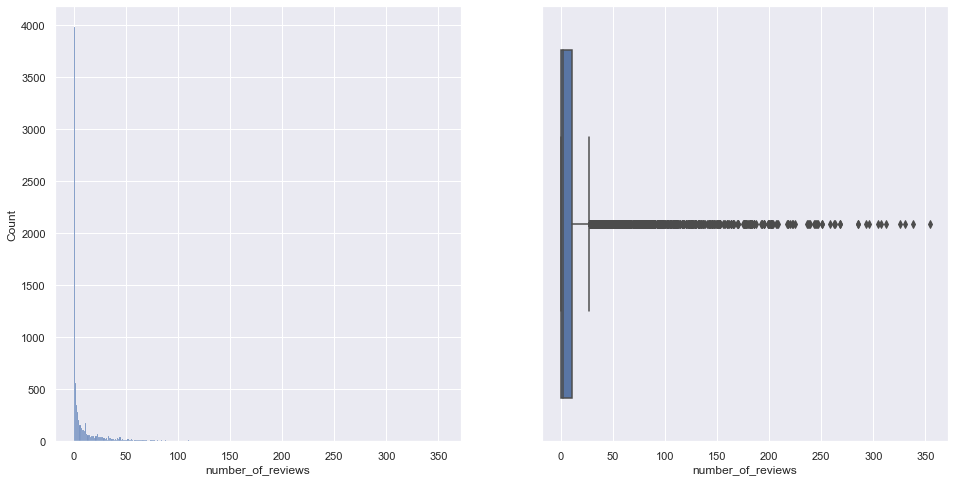

In [4]:
f ,ax = plt.subplots(1, 2, figsize=(16,8))

sns.histplot(x="number_of_reviews", data=df, ax=ax[0]);
sns.boxplot(x="number_of_reviews", data=df, ax=ax[1]);

Two glaring problems arise from the observation of our response feature:

1) Almost **50%** of the listings do not have any reviews  
2) The distribution of non-zero values is massive  

To address these issues, we decided to tackle our dataset from a different direction; that is, to transform it into a classification problem. We make the shallow assumption that listings with no reviews are simply not as attractive.

### Cancelled bookings

In [5]:
df["has_cancelled"] = 0

In [6]:
df_reviews = pd.read_csv("data/reviews.csv")

id_dict = {}

for i in range(len(df_reviews)):
    
    list_id = df_reviews["listing_id"].iloc[i]
    
    tempstr1 = 'This is an automated posting.'
    tempstr2 = 'The host canceled this reservation'
    
    if (tempstr1 or tempstr2) in str(df_reviews["comments"].iloc[i]):
        
        if list_id not in id_dict:
            id_dict[list_id] = 1
        else:
            id_dict[list_id] += 1

In [7]:
for i in range(len(df)):
    
    list_id = df["id"].iloc[i]
    
    if list_id in id_dict:
        df["has_cancelled"].iloc[i] = 1
        
        df["number_of_reviews"].iloc[i] = df["number_of_reviews"].iloc[i] - id_dict[list_id]

In [8]:
df["number_of_reviews"].value_counts()

0      3076
1       996
2       534
3       344
4       266
       ... 
225       1
237       1
245       1
323       1
293       1
Name: number_of_reviews, Length: 214, dtype: int64

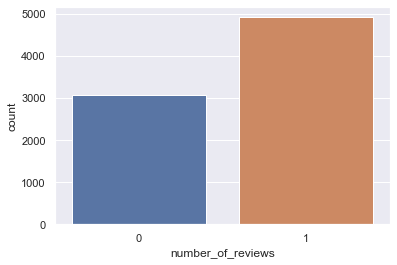

In [9]:
# Transform into classification problem
df.loc[(df["number_of_reviews"] <= 0), "number_of_reviews"] = 0
df.loc[(df["number_of_reviews"] > 0), "number_of_reviews"] = 1
sns.countplot(x="number_of_reviews", data=df);

# DATA CLEANING

## Label encoding for True/False features

In [10]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,has_cancelled
0,49091,https://www.airbnb.com/rooms/49091,20191228164401,2019-12-28,COZICOMFORT LONG TERM STAY ROOM 2,NaN,This is Room No. 2.(available after Jan 15 201...,This is Room No. 2.(available after Jan 15 201...,none,NaN,NaN,NaN,NaN,NaN,No smoking indoors. Please turn off lights/fan...,NaN,NaN,https://a0.muscache.com/im/pictures/24485541/6...,NaN,266763,https://www.airbnb.com/users/show/266763,Francesca,2010-10-20,singapore,I am a private tutor by profession. My husband...,within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/c9b1c...,https://a0.muscache.com/im/pictures/user/c9b1c...,Woodlands,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,"Singapore, Singapore",Woodlands,Woodlands,...,180,360,180,180,360,360,180.0,360.0,67 months ago,t,30,60,90,365,2019-12-28,1,0,2013-10-21,2013-10-21,94.0,10.0,10.0,10.0,10.0,8.0,8.0,f,NaN,NaN,f,f,flexible,t,t,2,0,2,0,0.01,0
1,50646,https://www.airbnb.com/rooms/50646,20191228164401,2019-12-28,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,"Good Condition room, bright & windy. Comes wit...",Fully furnished bedroom with a nice view on th...,none,The serenity & quiet surrounding makes it an i...,Accommodation has a queen size bed. Suitable ...,Less than 400m from the apartment is the main ...,"Kitchen, washing facilities, gym, swimming poo...",We love to host people & have the opportunity ...,'- Should be family friendly. '- Cooking is no...,NaN,NaN,https://a0.muscache.com/im/pictures/36342984/6...,NaN,227796,https://www.airbnb.com/users/show/227796,Sujatha,2010-09-08,"Singapore, Singapore","I am a working professional, living in Singapo...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/8fd2c...,https://a0.muscache.com/im/pictures/user/8fd2c...,Bukit Timah,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,f,"Singapore, Singapore",Bukit Timah,Bukit Timah,...,90,730,90,90,730,730,90.0,730.0,65 months ago,t,30,60,90,365,2019-12-28,1,0,2014-04-18,2014-12-26,91.0,9.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,f,moderate,f,t,1,0,1,0,0.26,0
2,56334,https://www.airbnb.com/rooms/56334,20191228164401,2019-12-28,COZICOMFORT,NaN,This is Room no. 1. USD700 per month On the fa...,This is Room no. 1. USD700 per month On the fa...,none,NaN,NaN,NaN,NaN,NaN,No smoking indoors. Please turn off lights/air...,NaN,NaN,https://a0.muscache.com/im/pictures/20783922/1...,NaN,266763,https://www.airbnb.com/users/show/266763,Francesca,2010-10-20,singapore,I am a private tutor by profession. My husband...,within a few hours,100%,NaN,f

A few features are booleans, represented by **"t"** and **"f"** in the dataset. We will encode these features such that our models can work with them.

In [11]:
cols = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "is_location_exact", 
        "instant_bookable", "require_guest_profile_picture", "require_guest_phone_verification"]

for col in cols:

    df[col] = df[col].replace({"t":1, "f":0})

## Handling missing values

In [12]:
# Display missing values
def missing_values(df):
    
    size = len(df)
    
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/size*100).sort_values(ascending=False)

    missing_data = pd.concat([total, round(percent, 3)], axis=1, keys=['Total', 'Percent'])
    
    return missing_data

We will check for missing values in the dataset.

In [13]:
missing_values(df).head(20)

,Total,Percent
medium_url,8000,100.000
jurisdiction_names,8000,100.000
host_acceptance_rate,8000,100.000
xl_picture_url,8000,100.000
thumbnail_url,8000,100.000
license,7995,99.938
square_feet,7960,99.500
weekly_price,7494,93.675
monthly_price,7414,92.675
state,7378,92.225


We will remove **jurisdiction_names**, **host_acceptance_rate**, **xl_picture_url**, **medium_url** and **thumbnail_url** because the entire column is empty.

In [14]:
df.drop(["jurisdiction_names", "host_acceptance_rate", "xl_picture_url", "medium_url", "thumbnail_url"], axis=1, inplace=True)

**license**, **square_feet**, **weekly_price**, and **monthly_price** have so many missing values such that they are barely salvageable. We will remove those features as well.

In [15]:
df.drop(["license", "square_feet", "weekly_price", "monthly_price"], axis=1, inplace=True)

### review_scores

Our response variable is **number_of_reviews**. If a **number_of_reviews** is ZERO, all other "review-related" features will be NaN. Thus, to only have one response variable, we will remove all other "review-related" features.

In [16]:
df.drop(["review_scores_value", "review_scores_location", "review_scores_checkin", "review_scores_accuracy",
         "review_scores_communication", "review_scores_cleanliness", "review_scores_rating", "first_review", 
         "last_review", "reviews_per_month", "number_of_reviews_ltm"], axis=1, inplace=True)

We will check for missing values again.

In [17]:
missing_values(df).head(15)

,Total,Percent
state,7378,92.225
house_rules,4141,51.762
interaction,3389,42.362
notes,3326,41.575
transit,3265,40.812
neighborhood_overview,3249,40.613
access,2911,36.388
host_about,2774,34.675
security_deposit,2307,28.838
space,2050,25.625


### security_deposit & cleaning_fee

The features `security_deposit` and `cleaning_fee` are wrongly formatted. Let us take care of that first.

In [18]:
df["security_deposit"] = df["security_deposit"].str.lstrip("$")
df["security_deposit"] = df["security_deposit"].str.replace(",", "_")
df["security_deposit"] = df["security_deposit"].astype("float")

df["cleaning_fee"] = df["cleaning_fee"].str.lstrip("$")
df["cleaning_fee"] = df["cleaning_fee"].str.replace(",", "_")
df["cleaning_fee"] = df["cleaning_fee"].astype("float")

Mean 	: 244.236
Median 	: 150.000


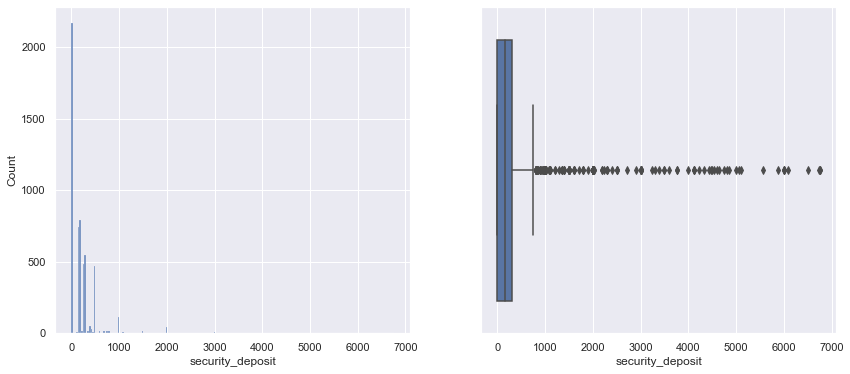

In [19]:
print("Mean \t: {:.3f}".format(df["security_deposit"].mean()))
print("Median \t: {:.3f}".format(df["security_deposit"].median()))

f, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(x="security_deposit", data=df, ax=ax[0]);
sns.boxplot(x="security_deposit", data=df, ax=ax[1]);

Mean 	: 38.927
Median 	: 30.000


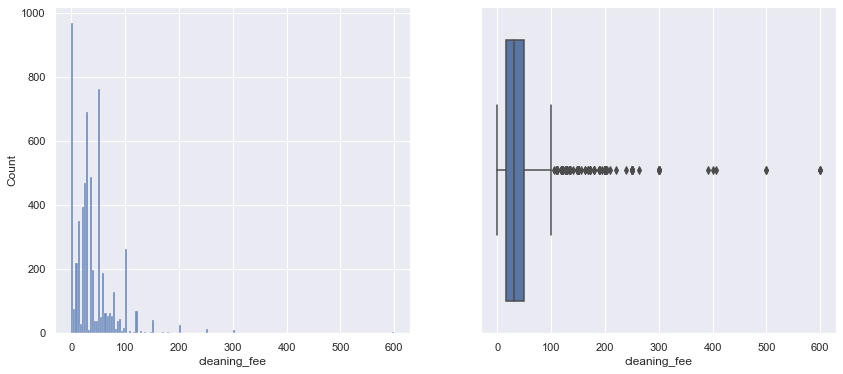

In [20]:
print("Mean \t: {:.3f}".format(df["cleaning_fee"].mean()))
print("Median \t: {:.3f}".format(df["cleaning_fee"].median()))

f, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(x="cleaning_fee", data=df, ax=ax[0]);
sns.boxplot(x="cleaning_fee", data=df, ax=ax[1]);

We could simply replace missing values with the calculated mean/median without much thought. However, closer inspection of the listings reveal a different story:

Listings that do not have a value for `security_deposit` or `cleaning_fee` **do not charge** customers these extra fees. Simply put: replace missing values with **'0'**.

In [21]:
df["security_deposit"].fillna(0, inplace=True)
df["cleaning_fee"].fillna(0, inplace=True)

### New feature: extra_cost_security, extra_cost_cleaning

In [22]:
df["extra_cost_security"] = 0
df["extra_cost_cleaning"] = 0

df.loc[(df["security_deposit"] != 0), "extra_cost_security"] = 1
df.loc[(df["cleaning_fee"] != 0), "extra_cost_cleaning"] = 1

### host_response_time & host_response_rate

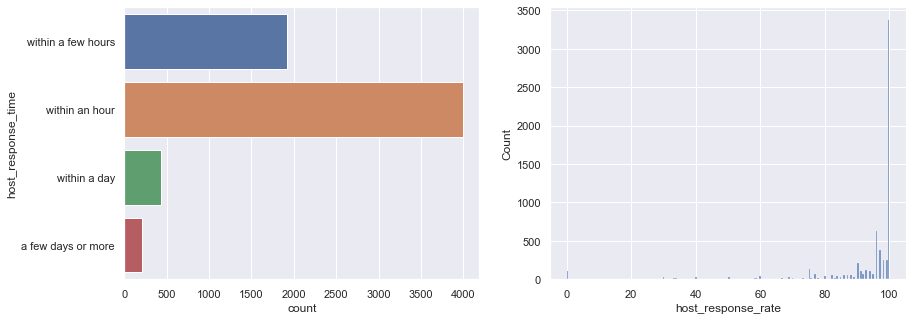

In [23]:
f, ax = plt.subplots(1, 2, figsize=(14,5))

df["host_response_rate"] = df["host_response_rate"].str.rstrip("%").astype("float")

sns.countplot(y="host_response_time", data=df, ax=ax[0]);
sns.histplot(x="host_response_rate", data=df, ax=ax[1]);

In [24]:
df["host_response_time"].fillna("within an hour", inplace=True)
df["host_response_rate"].fillna(df["host_response_rate"].mean(), inplace=True)

### beds

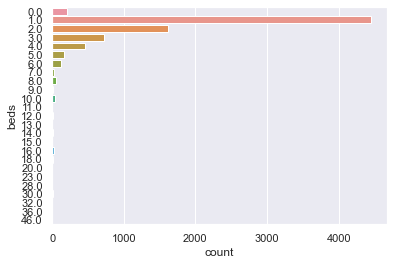

In [25]:
sns.countplot(y="beds", data=df);

In [26]:
df["beds"].fillna(df["beds"].mode()[0], inplace=True)

### host_has_profile_pic, host_identity_verified, host_is_superhost, host_listings_count

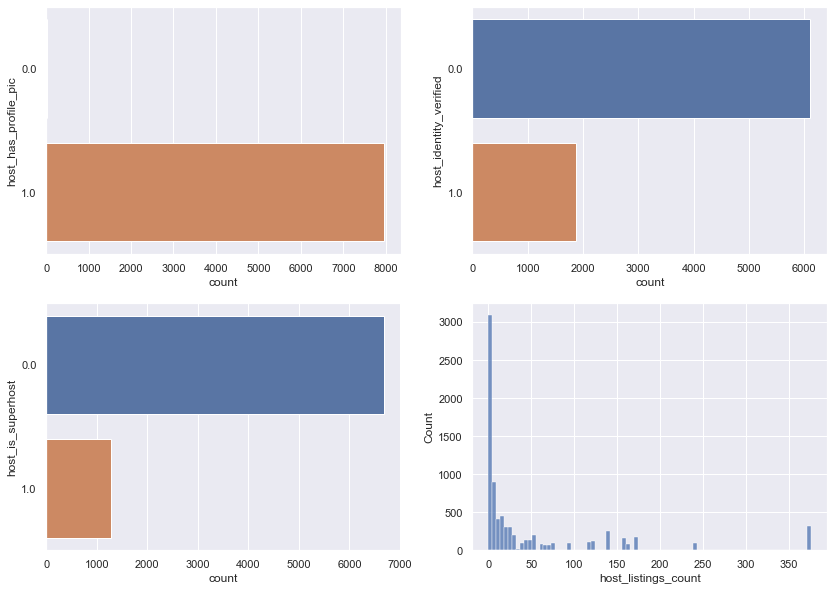

In [27]:
f, ax = plt.subplots(2, 2, figsize=(14,10))

sns.countplot(y="host_has_profile_pic", data=df, ax=ax[0,0]);
sns.countplot(y="host_identity_verified", data=df, ax=ax[0,1]);
sns.countplot(y="host_is_superhost", data=df, ax=ax[1,0]);
sns.histplot(x="host_listings_count", data=df, ax=ax[1,1]);

In [28]:
df["host_has_profile_pic"].fillna(df["host_has_profile_pic"].mode()[0], inplace=True)
df["host_identity_verified"].fillna(df["host_identity_verified"].mode()[0], inplace=True)
df["host_is_superhost"].fillna(df["host_is_superhost"].mode()[0], inplace=True)
df["host_listings_count"].fillna(df["host_listings_count"].mean(), inplace=True)

### bedrooms & bathrooms

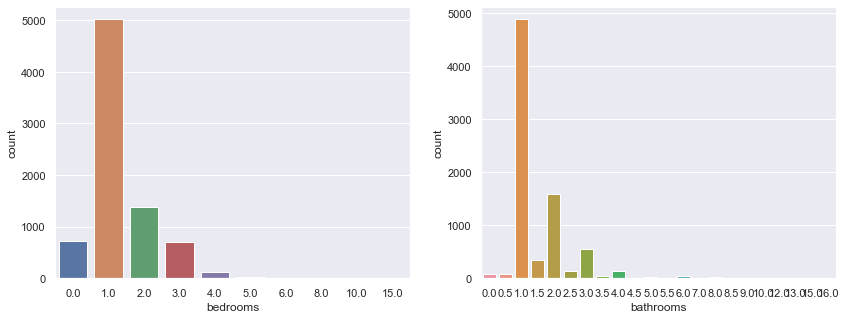

In [29]:
f, ax = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(x="bedrooms", data=df, ax=ax[0]);
sns.countplot(x="bathrooms", data=df, ax=ax[1]);

In [30]:
df["bedrooms"].fillna(df["bedrooms"].mode()[0], inplace=True)
df["bathrooms"].fillna(df["bathrooms"].mode()[0], inplace=True)

### host_since

In [31]:
from datetime import date

def convert_days(string):
    
    scrape_date = date(2019, 12, 28)
    
    lst = string.split("-")
    lst = list(map(int, lst))
    
    past_date = date(lst[0], lst[1], lst[2])
    
    delta = scrape_date - past_date
    
    return delta.days

In [32]:
df_notnull = df[df["host_since"].notnull()]
df_null = df[df["host_since"].isnull()]
df_notnull["host_since"] = df_notnull["host_since"].apply(convert_days)

df = pd.concat([df_notnull, df_null])

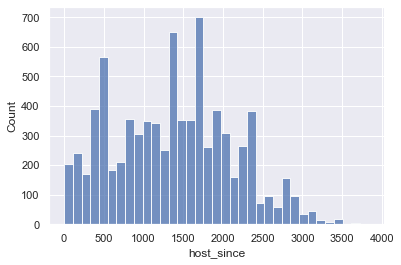

In [33]:
sns.histplot(x="host_since", data=df);

In [34]:
df["host_since"].fillna(df["host_since"].mean(), inplace=True)

### host_neighbourhood, neighbourhood

In [35]:
df_mrt = pd.read_csv("data/mrtsg.csv")

df_mrt.head()

,objectid,stn_name,stn_no,x,y,latitude,longitude,color,location
0,12,ADMIRALTY MRT STATION,NS10,24402.1063,46918.1131,1.440585,103.800998,RED,POINT(103.8009982 1.440585001)
1,16,ALJUNIED MRT STATION,EW9,33518.6049,33190.0020,1.316433,103.882893,GREEN,POINT(103.882893 1.316432612)
2,33,ANG MO KIO MRT STATION,NS16,29807.2655,39105.7720,1.369933,103.849553,RED,POINT(103.8495535 1.369933175)
3,81,BAKAU LRT STATION,SE3,36026.0821,41113.8766,1.388093,103.905418,OTHERS,POINT(103.9054179 1.388092704)
4,80,BANGKIT LRT STATION,BP9,21248.2460,40220.9693,1.380018,103.772667,OTHERS,POINT(103.7726667 1.380017897)


In [36]:
mrt_coords = list(zip(list(df_mrt["latitude"]), list(df_mrt["longitude"]), list(df_mrt["stn_name"])))

In [37]:
from geopy.distance import distance

def find_stn(df_lat, df_long):
    
    max_dist = 99999
    nearest = ""

    for stn in mrt_coords:

        lat = stn[0]
        long = stn[1]
        stn_name = stn[2]

        dist = distance((df_lat, df_long), (lat, long))

        if dist < max_dist:
            max_dist = dist
            nearest = stn_name
            
    return [round(max_dist.m, 3), nearest]

In [38]:
df["mrt_dist"] = np.NaN
df["mrt_name"] = ""

In [39]:
import time
start = time.time()

cp = len(df) // 200

for index in df.index:
    
    data = find_stn(df["latitude"].iloc[index], df["longitude"].iloc[index])
    
    if index % cp == 0:
        print("Checkpoint! {} out of {} done.".format(index, len(df)))
    
    df.at[index, "mrt_dist"] = data[0]
    df.at[index, "mrt_name"] = data[1]
    
end = time.time()
print("Time taken(s):", round(end - start, 3))

Checkpoint! 0 out of 8000 done.
Checkpoint! 40 out of 8000 done.
Checkpoint! 80 out of 8000 done.
Checkpoint! 120 out of 8000 done.
Checkpoint! 160 out of 8000 done.
Checkpoint! 200 out of 8000 done.
Checkpoint! 240 out of 8000 done.
Checkpoint! 280 out of 8000 done.
Checkpoint! 320 out of 8000 done.
Checkpoint! 360 out of 8000 done.
Checkpoint! 400 out of 8000 done.
Checkpoint! 440 out of 8000 done.
Checkpoint! 480 out of 8000 done.
Checkpoint! 520 out of 8000 done.
Checkpoint! 560 out of 8000 done.
Checkpoint! 600 out of 8000 done.
Checkpoint! 640 out of 8000 done.
Checkpoint! 680 out of 8000 done.
Checkpoint! 720 out of 8000 done.
Checkpoint! 760 out of 8000 done.
Checkpoint! 800 out of 8000 done.
Checkpoint! 840 out of 8000 done.
Checkpoint! 880 out of 8000 done.
Checkpoint! 920 out of 8000 done.
Checkpoint! 960 out of 8000 done.
Checkpoint! 1000 out of 8000 done.
Checkpoint! 1040 out of 8000 done.
Checkpoint! 1080 out of 8000 done.
Checkpoint! 1120 out of 8000 done.
Checkpoint! 11

In [40]:
df_neighbourless = df[df["neighbourhood"].isnull()]
df_neighbourfull = df[df["neighbourhood"].notnull()]

We don't have to rely on data from `df_train` only for the imputing of missing values. This is all geographical data, and is unaffected by other factors.

In [41]:
for index, row in df_neighbourless.iterrows():
    
    stn = row["mrt_name"]
    
    # We just directly replace with new value in the ORIGINAL DataFrame
    df_neighbourless.at[index, "neighbourhood"] = df[df["mrt_name"] == stn]["neighbourhood"].mode()[0]

In [42]:
df = pd.concat([df_neighbourless, df_neighbourfull])

print("Data dims = {}".format(df.shape))

Data dims = (8000, 91)


In [43]:
itc_stn = ["JURONG EAST MRT STATION", "BUONA VISTA MRT STATION", "HABOURFRONT MRT STATION", "OUTRAM PARK MRT STATION", 
           "MARINA BAY MRT STATION", "BOTANIC GARDENS MRT STATION", "BISHAN MRT STATION", "NEWTON MRT STATION", 
           "DHOBY GHAUT MRT STATION", "CHINATOWN MRT STATION", "RAFFLES PLACE MRT STATION", "CITY HALL MRT STATION", 
           "BAYFRONT MRT STATION", "BUGIS MRT STATION", "SERANGOON MRT STATION", "MACPHERSON MRT STATION", 
           "PAYA LEBAR MRT STATION", "PROMENADE MRT STATION", "LITTLE INDIA MRT STATION", "TAMPINES MRT STATION", 
           "EXPO MRT STATION"]

df["interchange"] = 0

for index in df.index:
    
    if df["mrt_name"].iloc[index] in itc_stn:
        df["interchange"].iloc[index] = 1

In [44]:
df["host_neighbourhood"].unique()

array([nan, 'Tanglin', 'Novena', 'Hougang', 'Katong', 'Kallang',
       'Central Area', 'Marine Parade', 'Geylang', 'Jurong West',
       'Bugis/Kampong Glam', 'Serangoon', 'Outram', 'Ang Mo Kio',
       'Bukit Merah', 'Little India', 'Chinatown', 'Toa Payoh', 'Bedok',
       'Riverside', 'Bukit Panjang', 'Bukit Timah', 'Queenstown',
       'Jurong East', 'Clementi', 'Fortress Hill', 'Woodlands',
       'Tampines', 'Dalston', 'Pasir Ris', 'Punggol', 'Bukit Batok',
       'Arab Street', 'Sembawang', 'Choa Chu Kang', 'Sengkang', 'Orchard',
       'Waikiki', 'Bishan', 'Marina Bay', 'Yishun', 'North Kuta',
       'Central Business District', 'Sathorn', 'Suan Luang',
       'West Kowloon', 'Dunbar-Southlands', 'Sungei Kadut', 'Sentosa',
       'Bastille', 'Keppel Bay', 'Mount Faber', 'Downtown Core', 'Siam',
       'Wan Chai', 'McGill Ghetto', 'River Valley', 'Pudu', 'Rochor',
       'Friedrichshain', 'Singapore River', 'Beguinage-Dixmude',
       'Thong Lo', 'Newton', 'Ala Moana/Kakaako'],

In [45]:
df.drop(["host_neighbourhood"], axis=1, inplace=True)

In [46]:
missing_values(df).head()

,Total,Percent
state,7378,92.225
house_rules,4141,51.762
interaction,3389,42.362
notes,3326,41.575
transit,3265,40.812


### Label encoding for other features

In [47]:
df["host_response_time"].replace({"within an hour":3, "within a few hours":2, 
                                  "within a day":1, "a few days or more":0}, inplace=True)

### Splitting "host_verifications" and "amenities"

In [48]:
verification_set = set()

for index in df.index:
    
    text = df['host_verifications'].iloc[index].replace("\'", "").replace("[", "").replace("]", "").replace(" ", "")
    
    verification_set.update(text.split(","))

In [49]:
start = time.time()

verification_types = list(verification_set)

verification_types.remove('')
verification_types.remove('None')


for types in verification_types:
    df[types] = ''

df['verify_count'] = 0

for index in df.index:
    
    if index % cp == 0:
        print("Checkpoint! {} out of {} done.".format(index, len(df)))
        
    text = df['host_verifications'].iloc[index].replace("\'", "").replace("[", "").replace("]", "").replace(" ", "")
    
    verification_list = text.split(",")
    
    try:
        verification_list.remove('None')
    except:
        pass
    
    
    for types in verification_types:
        
        if types in verification_list:
            df[types].iloc[index] = 1
            
        else:
            df[types].iloc[index] = 0
            
    df['verify_count'].iloc[index] = len(verification_list)
    
end = time.time()
print("Time taken(s):", round(end - start, 3))

Checkpoint! 7720 out of 8000 done.
Checkpoint! 7760 out of 8000 done.
Checkpoint! 7800 out of 8000 done.
Checkpoint! 7840 out of 8000 done.
Checkpoint! 7880 out of 8000 done.
Checkpoint! 7920 out of 8000 done.
Checkpoint! 7960 out of 8000 done.
Checkpoint! 0 out of 8000 done.
Checkpoint! 40 out of 8000 done.
Checkpoint! 80 out of 8000 done.
Checkpoint! 120 out of 8000 done.
Checkpoint! 160 out of 8000 done.
Checkpoint! 200 out of 8000 done.
Checkpoint! 240 out of 8000 done.
Checkpoint! 280 out of 8000 done.
Checkpoint! 320 out of 8000 done.
Checkpoint! 360 out of 8000 done.
Checkpoint! 400 out of 8000 done.
Checkpoint! 440 out of 8000 done.
Checkpoint! 480 out of 8000 done.
Checkpoint! 520 out of 8000 done.
Checkpoint! 560 out of 8000 done.
Checkpoint! 600 out of 8000 done.
Checkpoint! 640 out of 8000 done.
Checkpoint! 680 out of 8000 done.
Checkpoint! 720 out of 8000 done.
Checkpoint! 760 out of 8000 done.
Checkpoint! 800 out of 8000 done.
Checkpoint! 840 out of 8000 done.
Checkpoint!

In [50]:
amenities_set = set()

for index in df.index:
    
    text = df['amenities'].iloc[index].replace("\"", "").replace("{", "").replace("}", "").replace(" ", "")
    
    amenities_set.update(text.split(","))

In [51]:
start = time.time()

amenities_types = list(amenities_set)

amenities_types.remove('translationmissing:en.hosting_amenity_50')
amenities_types.remove('translationmissing:en.hosting_amenity_49')


for amenity in amenities_types:
    df[amenity] = ''

df['amenity_count'] = 0

for index in df.index:
    
    if index % cp == 0:
        print("Checkpoint! {} out of {} done.".format(index, len(df)))
        
    text = df['amenities'].iloc[index].replace("\"", "").replace("{", "").replace("}", "").replace(" ", "")
    
    amenities_list = text.split(",")
    
    try:
        amenities_list.remove('translationmissing:en.hosting_amenity_49')
    except:
        pass
    
    try:
        amenities_list.remove('translationmissing:en.hosting_amenity_50')
    except:
        pass
    
    
    for amenity in amenities_types:
        
        if amenity in amenities_list:
            df[amenity].iloc[index] = 1
            
        else:
            df[amenity].iloc[index] = 0
            
    df['amenity_count'].iloc[index] = len(amenities_list)
    
end = time.time()
print("Time taken(s):", round(end - start, 3))

Checkpoint! 7720 out of 8000 done.
Checkpoint! 7760 out of 8000 done.
Checkpoint! 7800 out of 8000 done.
Checkpoint! 7840 out of 8000 done.
Checkpoint! 7880 out of 8000 done.
Checkpoint! 7920 out of 8000 done.
Checkpoint! 7960 out of 8000 done.
Checkpoint! 0 out of 8000 done.
Checkpoint! 40 out of 8000 done.
Checkpoint! 80 out of 8000 done.
Checkpoint! 120 out of 8000 done.
Checkpoint! 160 out of 8000 done.
Checkpoint! 200 out of 8000 done.
Checkpoint! 240 out of 8000 done.
Checkpoint! 280 out of 8000 done.
Checkpoint! 320 out of 8000 done.
Checkpoint! 360 out of 8000 done.
Checkpoint! 400 out of 8000 done.
Checkpoint! 440 out of 8000 done.
Checkpoint! 480 out of 8000 done.
Checkpoint! 520 out of 8000 done.
Checkpoint! 560 out of 8000 done.
Checkpoint! 600 out of 8000 done.
Checkpoint! 640 out of 8000 done.
Checkpoint! 680 out of 8000 done.
Checkpoint! 720 out of 8000 done.
Checkpoint! 760 out of 8000 done.
Checkpoint! 800 out of 8000 done.
Checkpoint! 840 out of 8000 done.
Checkpoint!

In [52]:
df.drop(['host_verifications', 'amenities'], axis=1, inplace=True)

In [53]:
df.drop(['neighbourhood', 'longitude', 'latitude', 'mrt_name'], axis=1, inplace=True)

## Outlier removal for price-related features

In [54]:
from scipy import stats

outlier_features_list = ["price", "security_deposit", "cleaning_fee"]

z_temp = np.abs(stats.zscore(df[outlier_features_list]))

df = df[(z_temp < 3).all(axis=1)]

## Remove unnecessary features

There are many, many features that we found to be irrelevant. The dataset is further split into three sections. Pictoral/imagery data, textual/descriptive data, and finally categorical/numerical data that we are familiar with.

In [55]:
# Pictoral data
df_pictoral = df[["picture_url", "host_thumbnail_url", "host_picture_url"]]

In [56]:
# Textual / descriptor data
df_textual = df[["name", "summary", "space", "description", "neighborhood_overview", "notes", "transit", "access", 
              "interaction", "house_rules", "host_about", "host_location"]]

In [57]:
# Irrelevant data (eg. only one value, repeated data)
df.drop(["listing_url", "scrape_id", "last_scraped", "host_id", "host_url", "host_name", "street", "city", 
         "state", "market", "smart_location", "country_code", "country", "minimum_minimum_nights", "has_availability", 
         "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm", 
         "maximum_nights_avg_ntm", "calendar_last_scraped", "requires_license", "is_business_travel_ready", 
         "picture_url", "host_thumbnail_url", "host_picture_url", "name", "summary", "space", "description", 
         "neighborhood_overview", "notes", "transit", "access", "interaction", "house_rules", "host_about", 
         "host_location", "host_total_listings_count", "experiences_offered", "zipcode", "calendar_updated"], 
         axis=1, inplace=True)

In [58]:
print("Data dims = {}".format(df.shape))

Data dims = (7732, 191)


In [59]:
df.drop([""], axis=1, inplace=True)
df.rename(columns={"Children’sbooksandtoys":"Childrensbooksandtoys", "Children’sdinnerware":"Childrensdinnerware", 
                  "Pack’nPlay/travelcrib":"PacknPlay_travelcrib"}, inplace=True)

In [60]:
df.to_csv("listings_cleaned_clf.csv")